Processing WWU Cryo Data
============

Overview
--------
This document describes how to load and process paleomagnetic (AF demagnetization) data from the WWU cryogenic magnetometer using [Pandas](http://pandas.pydata.org/), [matplotlib](http://matplotlib.org/), and [iPmag](http://pmagpy.github.io/Example_PmagPy_Notebook.html). It assumes that you have [Enthought Canopy](https://www.enthought.com/academic-subscriptions/) installed, since that allows you to use the Python programming language, and [PmagPy](http://pmagpy.github.io/) paleomagnetic tools. In this example, we will cover:
* Loading data to memory from disk
* Producing a Zijderveld vector-endpoint plot to show remanent magnetization directions
* Producing a vector-difference-sum plot to show the decay of remanent magnetization during demagnetization
* Calculating principal component directions following Kirschvink (1980)
* Displaying data on an equal area diagram
* Calculating site statistics

Note: to run a code block (one of the segments of commands that starts with `"In [#]:"`), highlight it and press CTRL+ENTER (CMD+ENTER on a Mac) or press the play button. 

Initial setup
--------------
Assuming you have installed pmagpy and ipmag following the [directions given in Nick's workbook](http://pmagpy.github.io/Example_PmagPy_Notebook.html), import the numpy, pandas, and matplotlib libraries, as well as a couple of other useful ones, all of which should be installed when you install Canopy:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import requests
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

...now import the pmagpy and ipmag libraries:

In [2]:
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag

Note: to learn what fuctions are in the ipmag module, try this:

In [3]:
help(ipmag)

Help on module pmagpy.ipmag in pmagpy:

NAME
    pmagpy.ipmag

FILE
    c:\users\peter\appdata\local\enthought\canopy\user\lib\site-packages\pmagpy\ipmag.py

CLASSES
    __builtin__.object
        Site
    
    class Site(__builtin__.object)
     |  This Site class is for use within Jupyter/IPython notebooks. It reads in
     |  MagIC-formatted data (text files) and compiles fits, separates them by type,
     |  and plots equal-area projections inline. If means were not taken and output
     |  within the Demag GUI, it should automatically compute the Fisher mean for each
     |  fit type. Code is still a work in progress, but it is currently useful for
     |  succinctly computing/displaying data in notebook format.
     |  
     |  Methods defined here:
     |  
     |  __init__(self, site_name, data_path, data_format='MagIC')
     |      site_name: the name of the site
     |      data_path: put all MagIC data (text files) in a single directory and
     |      provide its path
     

Note that whenever these programs refer to "MagIC" or "Magic", they mean the Magnetics Information Consortium Database. 

Make a directory to store the processed data in, if it does not exist:

In [4]:
!mkdir Processed
!cd Processed

A subdirectory or file Processed already exists.


Loading data into memory
-------------------------
The data are stored on Dropbox, so you (and Python) can access them through the Web. WWU cryo data are stored in several files:
* A .loc file: This contains the locality and site information (e.g. hole names and locations). Not too important for us yet.

* A .sit file: This contains the specimen names within a site, referenced to numbers. Incidentally, the 0.0 90.0  0.0 etc. indicate the orientation of the specimen within the core.

* A .meas file: This contains the actual cryo measurements.

All of these are really text files - nothing special. We can download them with the requests and io packages and Pandas. What matters here is the "url"s (the dropbox share links to the files you want) and the names of the variables  in the last line of each block below. Note: you'll have to change the "dl=0" to "dl=1" in the link that you copy from dropbox.


In [5]:
url="https://www.dropbox.com/s/zrmldc33amgzjd1/EXP354.loc?dl=1" #<-- change this if you have a new locality file
s=requests.get(url).content
loc=pd.read_csv(io.StringIO(s.decode('utf-8')),delim_whitespace=1,header=None) ## Store the .loc file contents in the loc data frame

url="https://www.dropbox.com/s/bblh2sliucxso1l/U1454A.sit?dl=1" #<-- change this if you have a new site file
s=requests.get(url).content
sit=pd.read_csv(io.StringIO(s.decode('utf-8')),delim_whitespace=1,header=None) ## Store the .sit file contents in the sit data frame

url="https://www.dropbox.com/s/ocifgglfo1rpnuy/U1454A.mea?dl=1" #<-- change this if you have a new measurement file
s=requests.get(url).content
mea=pd.read_csv(io.StringIO(s.decode('utf-8')),delim_whitespace=1,header=None) ## Store the .mea file contents in the mea data frame

Check the site file to make sure things loaded OK...

In [8]:
mea

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1,0,mT,-4.704000e-08,2.440000e-08,-3.914000e-09,1.652000e-09,2.614000e-09,4.716000e-09,8,NRM,06-30-16,10:48,JR,0.0
1,2,0,mT,-9.661000e-08,-5.731000e-08,3.573000e-08,3.446000e-09,4.268000e-09,7.796000e-09,8,NRM,06-30-16,10:56,JR,0.0
2,1,10,mT,1.010000e-09,2.115000e-08,-1.237000e-08,1.865000e-09,1.276000e-09,2.815000e-09,8,NRM,06-30-16,11:21,JR,0.0
3,2,10,mT,-2.607000e-08,-5.041000e-08,2.408000e-08,2.429000e-09,2.921000e-09,3.088000e-09,8,NRM,06-30-16,11:25,JR,0.0
4,3,0,mT,-9.765000e-08,-1.034000e-07,-2.321000e-08,2.992000e-09,4.148000e-09,7.898000e-09,8,NRM,06-30-16,11:35,MB,0.0
5,4,0,mT,-1.145000e-07,-1.191000e-07,1.200000e-08,7.378000e-09,4.454000e-09,9.374000e-09,8,NRM,06-30-16,11:39,MB,0.0
6,3,10,mT,-1.187000e-08,-8.159000e-08,-2.867000e-08,3.688000e-09,3.841000e-09,4.352000e-09,8,NRM,06-30-16,11:48,MB,0.0
7,4,10,mT,-2.384000e-08,-9.656000e-08,3.096000e-09,2.400000e-09,2.212000e-09,5.450000e-09,8,NRM,06-30-16,11:52,MB,0.0
8,5,0,mT,-1.011000e-07,-1.136000e-07,-1.056000e-09,1.367000e-08,1.306000e-08,7.609000e-09,8,NRM,06-30-16,12:01,MB,0.0
9,6,0,-1.004E-07,-5.782000e-08,1.815000e-08,2.936000e-09,9.666000e-09,5.789000e-09,8.000000e+00,NRM,06-30-16,12:05,MB,0,NaN


Note: the following step is going to be useful for determining sample depths

In [7]:
url="https://www.dropbox.com/s/4j9zo5xi6e8fnlk/Kochi%20Samples.csv?dl=1" #<-- change this if you have a new Sample Info file
s=requests.get(url).content
sam=pd.read_csv(io.StringIO(s.decode('utf-8')),sep=',') ## Store the Sample Info file contents in the sam data frame

In [8]:
sam.head()

,Exp,Site,Hole,Core,Type,Section,Section half,Top Offset (cm),Bottom Offset (cm),Volume (cc),Sample Request CODE,"Comment, less than 100 characters, no special characters"
0,354,U1449,A,1,H,1,W,80.0,82.0,7.0,SELK,NaN
1,354,U1449,A,1,H,2,W,83.0,85.0,7.0,SELK,NaN
2,354,U1449,A,1,H,3,W,72.0,74.0,7.0,SELK,NaN
3,354,U1449,A,1,H,4,W,50.0,52.0,7.0,SELK,NaN
4,354,U1449,A,1,H,5,W,29.0,31.0,7.0,SELK,NaN


In [9]:
sit.index=sit[1] # Set the index of the Site data frame to be the specimen number
mea.index=sit.loc[mea[0]][0] # Set the index of the Measurement data frame to be the specimen ID
set(mea.index) # List all of the unique specimen IDs so you can copy them below

{'1H-1W-123-125',
 '1H-1W-15-17',
 '1H-1W-47-49',
 '1H-1W-90-92',
 '1H-2W-12-14',
 '1H-2W-120-122',
 '1H-2W-30-32',
 '1H-2W-62-64'}

In [28]:
print(mea.ix[1,3:5],
    pmag.cart2dir(np.array(mea.ix[1,3:5])))

(3   -9.661e-08
4   -5.731e-08
5    3.573e-08
Name: 1H-1W-47-49, dtype: object, array([  2.10676834e+02,   1.76449268e+01,   1.17875193e-07]))


In [36]:
dec
inc
mag

array([  5.31360612e-08,   1.17875193e-07,   2.45226324e-08,
         6.16494882e-08,   1.44103389e-07,   1.65647397e-07,
         8.72914309e-08,   9.95076098e-08,   1.52076577e-07,
         6.06728522e-08,   8.92150976e-08,   4.55041748e-08,
         5.83562199e-08,   7.26146176e-08,   5.86768292e-08,
         3.63119009e-08,   2.48078959e-08,   4.98771000e-08,
         7.27461147e-08,   8.16186615e-08,   7.62748651e-08,
         3.75988219e-08,   3.20609520e-08,   5.36364159e-08,
         4.12223398e-08,   3.11450388e-08,   6.31544799e-08,
         2.29726400e-08,   6.74212318e-08,   6.04461682e-08,
         2.75952721e-08,   4.92586953e-08,   2.11994471e-08,
         3.35564971e-08,   5.25130586e-08,   2.52531746e-08,
         4.94344388e-08,   5.33671631e-08,   4.53686729e-08,
         2.42519324e-08,   2.74236358e-08,   1.96557701e-08,
         2.06383403e-08,   4.30148079e-08,   3.93578319e-08,
         4.23186626e-08,   2.09913262e-08,   4.11770270e-08,
         1.64223056e-08,

In [10]:
!cd C:\Users\Peter\Documents\Notebooks
(dec,inc,mag)=pmag.cart2dir(np.array(mea.ix[:,3:5])).T
pmag.cart2dir(np.array(mea.ix[1,3:5]))
generic=pd.DataFrame({'treatment':pd.to_numeric(mea[1]),
                      'treatment_type':'AF',
                      'moment':mag,
                      'dec_s':dec,
                      'inc_s':inc})
generic.index.name='specimen'
generic.to_csv('Processed/generic.txt',sep='\t')

In [55]:
%run ~\Documents\PmagPy\programs\generic_magic.py -user Peter Selkin -f generic.txt -exp Demag -samp 2 ' -loc 354-U1454A -WD Processed

-I- Cant find file er_samples.txt
-I- sample information will be stored in new er_samples.txt file
-W- WARNING: missing sample_dip or sample_azimuth for sample 1H-1W-123-125
-W- WARNING: missing sample_dip or sample_azimuth for sample 1H-1W-123-125
-W- WARNING: missing sample_dip or sample_azimuth for sample 1H-1W-123-125
-W- WARNING: missing sample_dip or sample_azimuth for sample 1H-1W-123-125
-W- WARNING: missing sample_dip or sample_azimuth for sample 1H-1W-123-125
-W- WARNING: missing sample_dip or sample_azimuth for sample 1H-1W-123-125
-W- WARNING: missing sample_dip or sample_azimuth for sample 1H-1W-123-125
-W- WARNING: missing sample_dip or sample_azimuth for sample 1H-1W-15-17
-W- WARNING: missing sample_dip or sample_azimuth for sample 1H-1W-15-17
-W- WARNING: missing sample_dip or sample_azimuth for sample 1H-1W-15-17
-W- WARNING: missing sample_dip or sample_azimuth for sample 1H-1W-15-17
-W- WARNING: missing sample_dip or sample_azimuth for sample 1H-1W-15-17
-W- WARNING

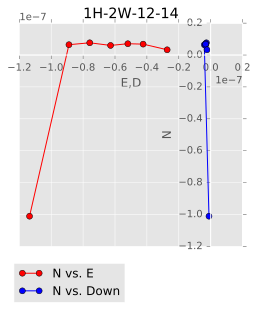

In [10]:
id='1H-2W-12-14' # The ID of the specimen whose data you want to plot
x=mea.loc[id][3] # Select the x, y, and z data from lines in the measurement file that refer to the right specimen 
y=mea.loc[id][4]
z=mea.loc[id][5]
plt.style.use('ggplot') # A plot style I like (looks nice, consistent with the R programming language)
HORZ,=plt.plot(y,x,'ro-') # Plot x-y data with North (x) pointing up
VERT,=plt.plot(z,x,'bo-') # Plot x-z data with North (x) pointing up
plt.axis('square') # Make the horizontal and vertical axis scales the same
ax=plt.gca()
ax.spines['left'].set_position('zero') # Set the left axis to cross the bottom axis at 0 
ax.spines['bottom'].set_position('zero') # Set the bottom axis to cross the left axis at 0 
plt.xlabel('E,D') # Label axes
plt.ylabel('N')
ax.legend((HORZ,VERT),('N vs. E','N vs. Down'),loc='upper right',shadow=False, bbox_to_anchor=(0.5, -0.05)) # Add a legend
plt.title(id) # Add a title